In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time

from itertools import chain, product
from functools import reduce

from qutip import Options, fidelity, rhs_generate, mesolve
from atom_config import rb_atom_config
from ketbra_config import rb_atom_ketbras

In [2]:
#List the groundstates to be included in the simulation

atomStates = {
    "g1M":0, "g1":1, "g1P":2, # F=1,mF=-1,0,+1 respectively
    "g2MM":3, "g2M":4, "g2":5, "g2P":6, "g2PP":7 # F=2,mF=-2,..,+2 respectively
}

# List the excited levels to include in the simulation. the _d1 levels correspond to the D1 line levels, the other levels are by default the d2 levels
xlvls = [
#'x0',
#'x1M','x1','x1P',
#'x2MM','x2M','x2','x2P','x2PP',
#'x3MMM', 'x3MM','x3M','x3','x3P','x3PP', 'x3PPP',
'x1M_d1','x1_d1','x1P_d1',
'x2MM_d1','x2M_d1','x2_d1','x2P_d1','x2PP_d1'
]

#configure the atm state dictionary such that it includes the desired excited states, this includes the desired ground and excited states as arguments, 
# as well as a boolean for whether to include the photonic Hilbert space

kb_class=rb_atom_ketbras(atomStates, xlvls, False)

#precompute ketbras for speed
ketbras=kb_class.getrb_ketbras()

In [3]:
#specify system b field groundstate splitting in MHz
bfieldsplit = '15'
#configure rb atom with desired CG coefficients and splittings
rb_atom = rb_atom_config(bfieldsplit, kb_class)

In [4]:
%%capture
#configure energy splittings from external CSV file and rb_atom_config class
[deltaZ,deltaEx3,deltaEx1,deltaEx0,\
        deltaZx3MMM,\
        deltaZx3MM,deltaZx2MM,\
        deltaZx3M,deltaZx2M,deltaZx1M,\
        deltaZx3,deltaZx2,deltaZx1,deltaZx0,\
        deltaZx3P,deltaZx2P,deltaZx1P,\
        deltaZx3PP,deltaZx2PP,\
        deltaZx3PPP ,
        deltaZ_d1,deltaEx1_d1,\
        deltaZx2MM_d1,\
        deltaZx2M_d1,deltaZx1M_d1,\
        deltaZx2_d1,deltaZx1_d1,\
        deltaZx2P_d1,deltaZx1P_d1,\
        deltaZx2PP_d1]=rb_atom.getrb_splittings_couplings()[0]

#configure Clebsch Gordan coefficients from external CSV file and atom_state_config class 
[CGg1Mx3MM, CGg1Mx2MM, \
        CGg1x3M, CGg1x2M, CGg1x1M, CGg1Mx3M, CGg1Mx2M, CGg1Mx1M, \
        CGg1Px3, CGg1Px2, CGg1Px1, CGg1Px0, CGg1x3, CGg1x2, CGg1x1, CGg1x0, CGg1Mx3, CGg1Mx2, CGg1Mx1, CGg1Mx0, \
        CGg1Px3P, CGg1Px2P, CGg1Px1P, CGg1x3P, CGg1x2P, CGg1x1P, \
        CGg1Px3PP,CGg1Px2PP,
        CGg2MMx3MMM, \
        CGg2Mx3MM, CGg2Mx2MM, CGg2MMx3MM, CGg2MMx2MM, \
        CGg2x3M, CGg2x2M, CGg2x1M, CGg2Mx3M, CGg2Mx2M, CGg2Mx1M, CGg2MMx3M, CGg2MMx2M, CGg2MMx1M, \
        CGg2Px3, CGg2Px2, CGg2Px1, CGg2Px0, CGg2x3,  CGg2x2, CGg2x1, CGg2x0, CGg2Mx3, CGg2Mx2, CGg2Mx1, CGg2Mx0, \
        CGg2PPx3P, CGg2PPx2P, CGg2PPx1P, CGg2Px3P, CGg2Px2P,  CGg2Px1P, CGg2x3P, CGg2x2P, CGg2x1P, \
        CGg2PPx3PP, CGg2PPx2PP, CGg2Px3PP, CGg2Px2PP, \
        CGg2PPx3PPP,
        CG_d1g1Mx2MM, \
        CG_d1g1x2M, CG_d1g1x1M, CG_d1g1Mx2M, CG_d1g1Mx1M, \
        CG_d1g1Px2, CG_d1g1Px1, CG_d1g1x2, CG_d1g1x1,  CG_d1g1Mx2, CG_d1g1Mx1, \
        CG_d1g1Px2P, CG_d1g1Px1P, CG_d1g1x2P, CG_d1g1x1P, \
        CG_d1g1Px2PP,
        CG_d1g2Mx2MM, CG_d1g2MMx2MM, \
        CG_d1g2x2M, CG_d1g2x1M,CG_d1g2Mx2M, CG_d1g2Mx1M, CG_d1g2MMx2M, CG_d1g2MMx1M, \
        CG_d1g2Px2, CG_d1g2Px1,CG_d1g2x2, CG_d1g2x1, CG_d1g2Mx2, CG_d1g2Mx1,  \
        CG_d1g2PPx2P, CG_d1g2PPx1P, CG_d1g2Px2P,  CG_d1g2Px1P, CG_d1g2x2P, CG_d1g2x1P, \
        CG_d1g2PPx2PP, CG_d1g2Px2PP] = rb_atom.getrb_splittings_couplings()[1]

# List the coupling rates of the system.
#   gamma:  Decay of the atomic amplitude listed for d1 and d2 transitions.
# d: Dipole moment of either d1 or d2 transition
[gamma_d2,gamma_d1,d_d2,d_d1] = rb_atom.getrb_rates()

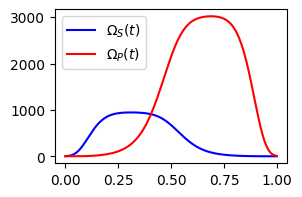

In [5]:
######For STIRAP Repreparation visualize the pulse shapes#####

#Define the repumping pulse parameters for special masked pulse shapes
#A*CG... - peak rabi frequency of the pulses
A_rep = 78
#make sure to add CG
[A_p,A_s] = [abs(x)*2*np.pi for x in [A_rep/CG_d1g2x1M,A_rep/CG_d1g1x1M]]
lengthGate=1
#dont start at 0 because otherwise the function is undefined at t=0
tGate,tGateStep = np.linspace(10**(-10), lengthGate, 500, retstep=True)

a=15
n=4
c=0.4
def stokes_shape_plot(t,T):
    return (np.exp(-((t - (T/2))/c)**(2*n))*np.cos(np.pi/2*(1/(1 + np.exp((-a*(t - T/2))/T)))))
def shape_pump_plot(t,T):
    return (np.exp(-((t - (T/2))/c)**(2*n))*np.sin(np.pi/2*(1/(1 + np.exp((-a*(t - T/2))/T)))))
                                                                                                                        
f, a1 = plt.subplots(figsize=(3, 2))
a1.plot(tGate, [A_s*stokes_shape_plot(x, lengthGate) for x in tGate], 'b',label='$\Omega_S(t)$')
a1.plot(tGate, [A_p*shape_pump_plot(x, lengthGate) for x in tGate], 'r',label='$\Omega_P(t)$')
a1.legend(loc=2)
f.patch.set_facecolor('white')

In [6]:
pump_amp_array=[]
stokes_amp_array=[]
for t in tGate:
    stokes_amp_array.append(stokes_shape_plot(t,tGate))
    pump_amp_array.append(shape_pump_plot(t,tGate))

In [7]:
print(tGate)

[1.00000000e-10 2.00400812e-03 4.00801613e-03 6.01202415e-03
 8.01603216e-03 1.00200402e-02 1.20240482e-02 1.40280562e-02
 1.60320642e-02 1.80360722e-02 2.00400803e-02 2.20440883e-02
 2.40480963e-02 2.60521043e-02 2.80561123e-02 3.00601203e-02
 3.20641284e-02 3.40681364e-02 3.60721444e-02 3.80761524e-02
 4.00801604e-02 4.20841684e-02 4.40881764e-02 4.60921845e-02
 4.80961925e-02 5.01002005e-02 5.21042085e-02 5.41082165e-02
 5.61122245e-02 5.81162326e-02 6.01202406e-02 6.21242486e-02
 6.41282566e-02 6.61322646e-02 6.81362726e-02 7.01402807e-02
 7.21442887e-02 7.41482967e-02 7.61523047e-02 7.81563127e-02
 8.01603207e-02 8.21643287e-02 8.41683368e-02 8.61723448e-02
 8.81763528e-02 9.01803608e-02 9.21843688e-02 9.41883768e-02
 9.61923849e-02 9.81963929e-02 1.00200401e-01 1.02204409e-01
 1.04208417e-01 1.06212425e-01 1.08216433e-01 1.10220441e-01
 1.12224449e-01 1.14228457e-01 1.16232465e-01 1.18236473e-01
 1.20240481e-01 1.22244489e-01 1.24248497e-01 1.26252505e-01
 1.28256513e-01 1.302605

In [8]:
from ham_sim_source import laserCoupling

print(laserCoupling(False,ketbras,1,"g1","x1M_d1",-200,{},array=True,amp_array=pump_amp_array,t_array=tGate))

0
1e-10


TypeError: can't convert complex to float

In [ ]:
#Constructing a SITRAP repumping Hamiltonian in accordance to the gen_H_Pulse function specified in rb_atom_config
#Define the arguments of the driving pulse in dictionary form and the driving pulse shape in form of a string,
#                                           which can be interpreted by cython with standards numpy commands, as well as the dictionary created
#additionally one needs to define the desired levels addressed by the STIRAP repumping transitions

#args_repump = dict([('n',n), ('c',c), ('a',a),('T', lengthRepump), ])

#pump_shape='np.exp(-((t - (T/2))/c)**(2*n))*np.sin(np.pi/2*(1/(1 + np.exp((-a*(t - T/2))/T))))'
#stokes_shape='np.exp(-((t - (T/2))/c)**(2*n))*np.cos(np.pi/2*(1/(1 + np.exp((-a*(t - T/2))/T))))'
delta_sti=-3000*2*np.pi
F_pump_start=2
F_pump_exc=1
F_stokes_start=1
F_stokes_exc=1

stokes_pol='sigmaM'
pump_pol='sigmaM'

H_Stirap_Stokes=rb_atom.gen_H_Pulse_D1(ketbras, atomStates, delta_sti,F_stokes_start,F_stokes_exc,stokes_pol,A_s, {},_array=True, _amp=stokes_amp_array, _t=tGate)
H_Stirap_Pump= rb_atom.gen_H_Pulse_D1(ketbras, atomStates, delta_sti,F_pump_start,F_pump_exc,pump_pol,A_p,{},_array=True,_amp=pump_amp_array, _t=tGate )

H_Gate =  list(chain(*[H_Stirap_Stokes[0], H_Stirap_Pump[0]]))
args_hams_Gate= {**H_Stirap_Stokes[1], **H_Stirap_Pump[1]}

In [ ]:
# A list of Hamiltonians to pre-compile in the form:
#    (Cythonised Hamiltonian, arguement dictionary, compiled file name)
H_list = [
    (H_Gate, args_hams_Gate, 'H_Gate')
]

#define list of collapse operators
c_op_list=[]

#by default we are adding the collapse operators for both the d2 and d1 line, but comment out either if only one is desired
#c_op_list += rb_atom.spont_em_ops(atomStates)[0] #d2 line
c_op_list+=rb_atom.spont_em_ops(atomStates)[1] #d1 line

H_rhs_compiled=[]

for H, args, label in H_list:
    t_start = time.time()
    rhs_generate(H, c_op_list, args=args, name=label, cleanup=True)
    H_rhs_compiled.append(H)
    print('Hamiltonian \'{0}\': states pre-computed in in {1} seconds'.format(label, time.time()-t_start))

/home/janole/control/rb_benchmarking/.venv/lib/python3.8/site-packages/qutip/cy/codegen.py:226: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.h_tdterms[ht] == "1.0":


Hamiltonian 'H_Gate': states pre-computed in in 5.182988405227661 seconds


In [ ]:
'''
Set up simulations
'''
#define length of each Hamiltonian, it might be interesting to pick a length longer than the individual pulse duration to consider the effect of non-unitary losses

psi0 = kb_class.get_ket_atomic('g2') # Initial state of the system in array format with dictionary, atomic state (atomStates, 'atomic state')
n_Cycles = 1 # Number of times to apply the sequence of actions defined in H_list

# The actions to apply in terms of a list of the form
#      (Cythonised Hamiltonian,
#       list of time steps,
#       argument dictionary,
#       compiled file name)
H_list = [
    (H_Gate,tGate, args_hams_Gate, 'H_Gate')
    ]

for H_info in H_list:
    if H_info[0] not in H_rhs_compiled:  print( 
      'WARNING: The Hamiltonian does not match the form of the \
      Hamiltonian pre-complied to Cython by Qutip.\n \
      Consider re-running the \'rhs_generate(...)\' function (i.e. the above cell hopefully)'
      )


In [ ]:
'''
Perform simulation
'''
#desired final state
psi_des=kb_class.get_ket_atomic('g1')

#we return the density operators after each simulation run for each timestep in the simulation and save it in a list called output states list

i, n_hams = 0, len(H_list)*n_Cycles
output_states_list = []
t_list = []
for H, t, args, label in H_list*n_Cycles:

    opts = Options(rhs_reuse=False,rhs_filename=label)
    t_start = time.time()
    
    output = mesolve(H, psi0, t, c_op_list, [], args=args, options=opts)
    
    i+=1
    print('Simulation {0}/{1} with {2} timesteps completed in {3} seconds'.format(
            i, n_hams, t.size,np.round(time.time()-t_start,3) ))
    
    output_states_list.append(output.states)
    t_list.append(t)

    psif=kb_class.recompute_psi(ketbras, output.states[-1])
    print("Gate Fidelity is:{}".format(fidelity(psif,psi_des)))

    

ValueError: Time lists are not compatible

In [ ]:
#pick the index of the Hamiltonian simulation you want to plot
ham_index=0
plot_output=output_states_list[ham_index]
plot_timelist=t_list[ham_index]

#plotting the results
#all plotting function require the following 4 arguments:
#ketbras: the configured ketbras of the system
#atomStates: the atomic groundstates of the system
#plot_output: the ouquantum object list outputted by the simulation
#plot_timelist: the list of timesteps for which the simulation was run
    #plotter_spontdecay_channels requires no additional arguments
    #plotter_atomstate_population requires a Boolean as to whether to include the excited state population relevant for the D1 transitions


rb_atom.plotter_spontdecay_channels( atomStates, plot_output,plot_timelist)
rb_atom.plotter_atomstate_population(ketbras, plot_output,plot_timelist, True)